In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle
from astropy import units as ut
import xml.etree.ElementTree as ET
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, LSR,HeliocentricMeanEcliptic
from matplotlib.gridspec import GridSpec
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import Gaussian_fitting as Gf
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from astropy.visualization.wcsaxes import SphericalCircle
import scipy as sp
from imp import reload
import glob

In [9]:
import sys,os
import Gaussian_fitting as Gf
#sys.path.append('../Absorption_fitting')
import spectra_decomposing as sd
import read_GASKAP_data as rd

In [10]:
datapathbase='/d/bip5/hchen'

# Gaussian_fitting

BIC  1270.277900980274 n=1
BIC  85.3774924639989 n= 2
BIC  84.49212162419553 n= 3
final n= 2


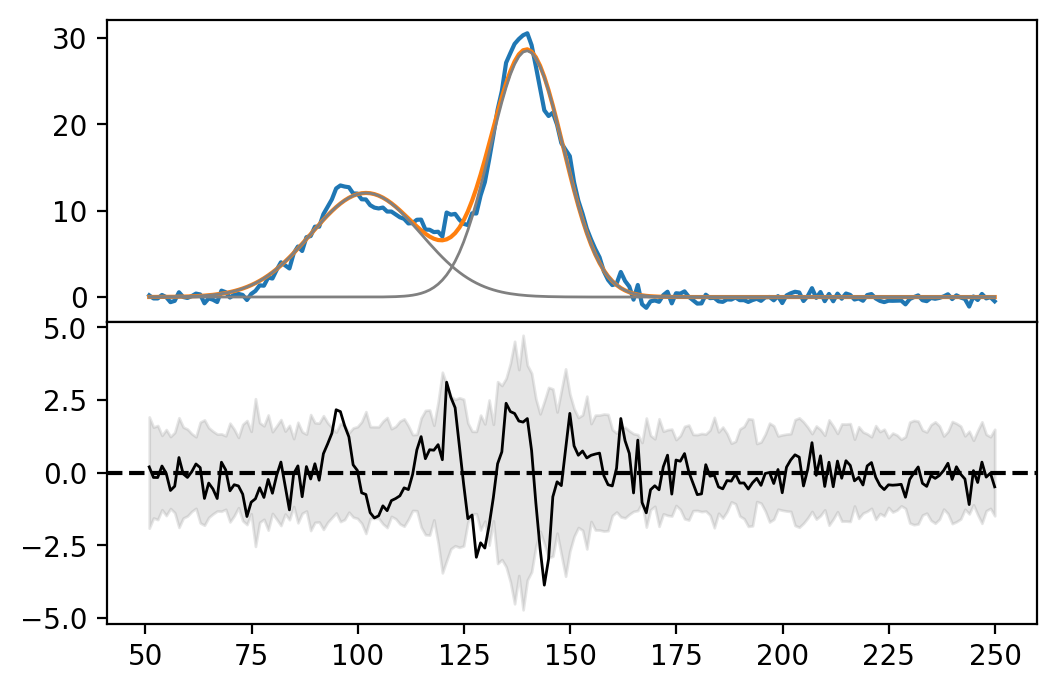

In [6]:

reload(Gf)
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
Gf.fitting_plot(x[p],yemi[p],yemi_err[p])

0.9999999999999999 2
0.9933120051943195 3
0.9999995125563601 4
0.06623722403620382 5


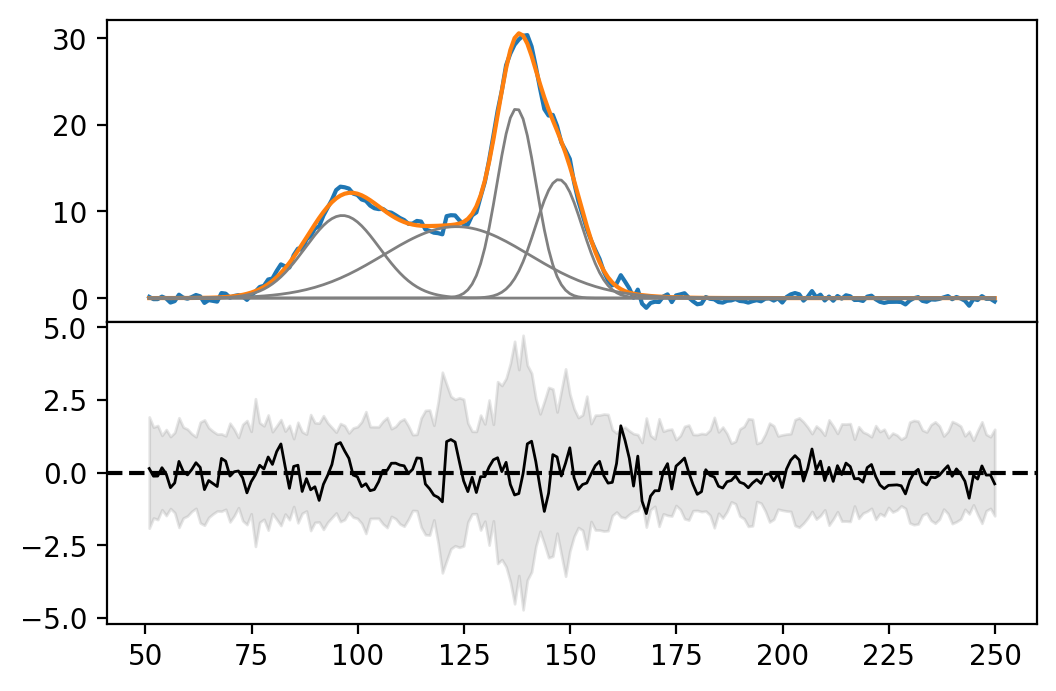

In [6]:
reload(Gf)
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
Gf.fitting_plot(x[p],yemi[p],yemi_err[p],fit_mode='F_test')

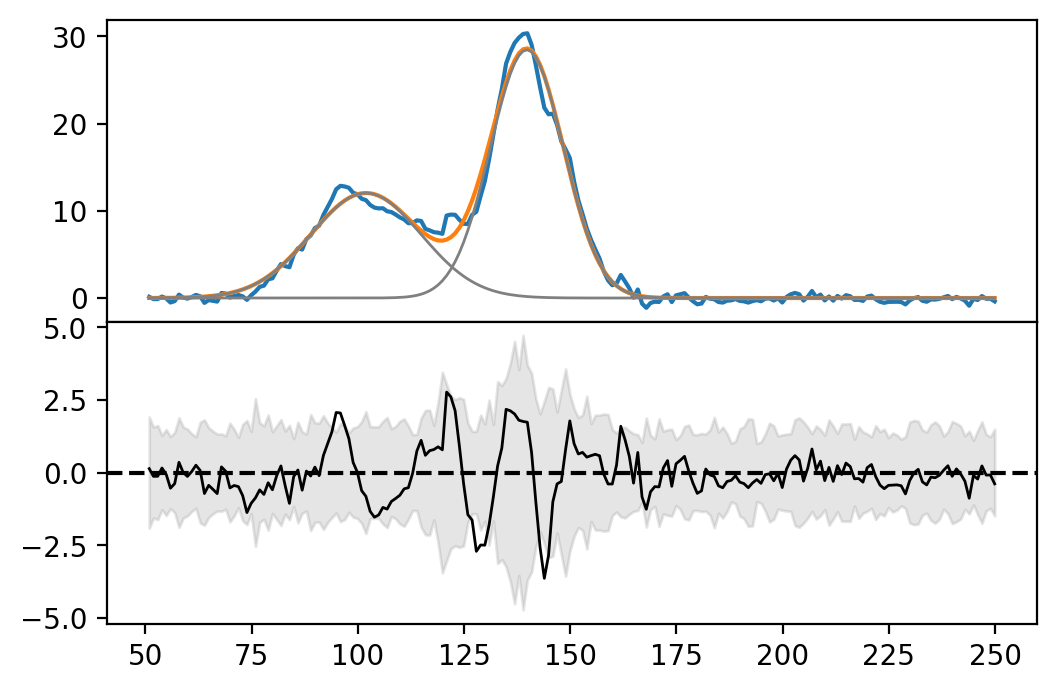

In [7]:
reload(Gf)
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
Gf.fitting_plot(x[p],yemi[p],yemi_err[p],x_peak=[150,100])

# spectra_decomposing

In [11]:
#print sources observed twice
nemi=np.sort(glob.glob(datapathbase+'/LMC_GASKAP_emi_all_abs/*.txt'))
nabs_n=glob.glob(datapathbase+'/LMC_abs_new/sb*')
nabs=[None] * len(nemi)
for i, ni in enumerate(nemi):
    na_=ni[-18:-4]
    for nj in nabs_n:
        _=glob.glob(nj+'/spectra_abs/*')
        _all=[filename[-23:-9] for filename in _]
        if na_ in _all:
            if nabs[i] is not None:
                print(i,nj,na_)
                break  # Exit the loop once a match is found for this `na_`
            else:
                nabs[i] = f'{nj}/spectra_abs/{na_}_spec.vot'  # Record `nj` only once for this `na_`
                
nemi,nabs=np.array(nemi),np.array(nabs)  
nlist=[filename[-18:-4] for filename in nemi]
              

25 /d/bip5/hchen/LMC_abs_new/sb38814 J045207-665520
48 /d/bip5/hchen/LMC_abs_new/sb33047 J050200-693158
54 /d/bip5/hchen/LMC_abs_new/sb38814 J050411-670107
57 /d/bip5/hchen/LMC_abs_new/sb38791 J050500-664520
58 /d/bip5/hchen/LMC_abs_new/sb38791 J050501-664516
61 /d/bip5/hchen/LMC_abs_new/sb38814 J050529-665556
62 /d/bip5/hchen/LMC_abs_new/sb38791 J050531-655515
64 /d/bip5/hchen/LMC_abs_new/sb38814 J050543-665813
69 /d/bip5/hchen/LMC_abs_new/sb38791 J050831-670609
80 /d/bip5/hchen/LMC_abs_new/sb38814 J050946-670557
85 /d/bip5/hchen/LMC_abs_new/sb38791 J051222-673218
96 /d/bip5/hchen/LMC_abs_new/sb38791 J051537-672127
98 /d/bip5/hchen/LMC_abs_new/sb38845 J051641-714905
113 /d/bip5/hchen/LMC_abs_new/sb38845 J052415-715800
138 /d/bip5/hchen/LMC_abs_new/sb38845 J053254-723155


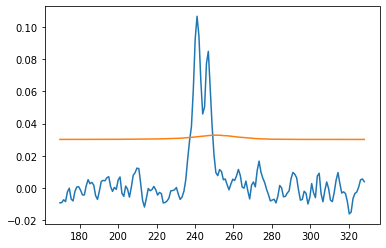

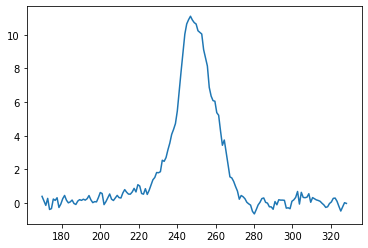

In [12]:
reload(rd)
j=0
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
plt.plot(x,1-np.exp(-y))
plt.plot(x,yerr*4.5)
plt.figure()
plt.plot(xemi,yemi)

Satuated
BIC  255.0120730684623 n=1
BIC  249.80523808657588 n= 2
BIC  259.14341642002125 n= 3
final n= 2
[  0.96890199 233.87127745   5.52343894   0.6138777  242.69236828
   1.47268921]


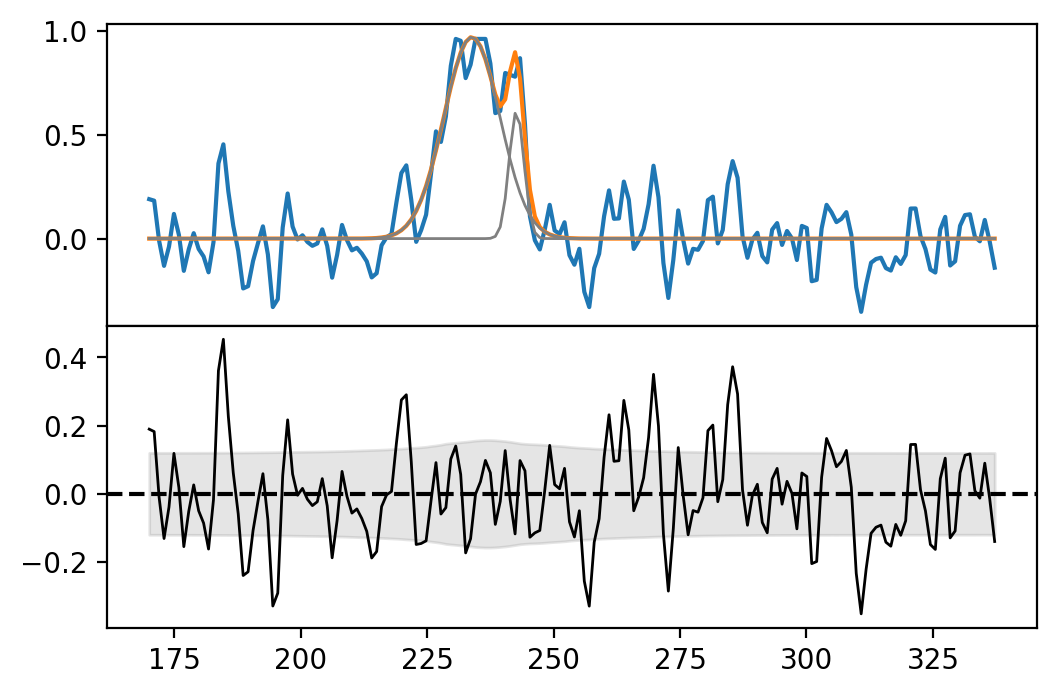

In [ ]:
reload(rd)
j=0
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
reload(Gf)
#Gf.fitting_plot(x,y,yerr,x_peak=[3.12835286e+02,2.61895645e+02+10])
Gf.fitting_plot(x,1-np.exp(-y),yerr)
#Gf.fitting_plot(x,y,yerr)

BIC  243.11017371653708 n=1
BIC  156.98423437375848 n= 2
BIC  181.3420968595799 n= 3
final n= 2
[240.99856315 246.98953036]
BIC= 158.1796356180015
popt_ori [1.07848479e-01 2.41007492e+02 2.06935252e+00 8.43374388e-02
 2.46968177e+02 1.57318388e+00]
Ts_low limit [10.477354484452576, 20.36369089408149]
origin BIC  658.1699547889993 Original_Mean_score  658.2056734050318
BIC  51.445898988651265 Mean_score  51.49934031706636
BIC  58.98551765549689 Mean_score  58.9995018573219
Ts>3.77 (6,)
Ts>3.77 (6,)
final BIC  61.445898988651265
51.445898988651265
velocity shift [4.         3.60315283]



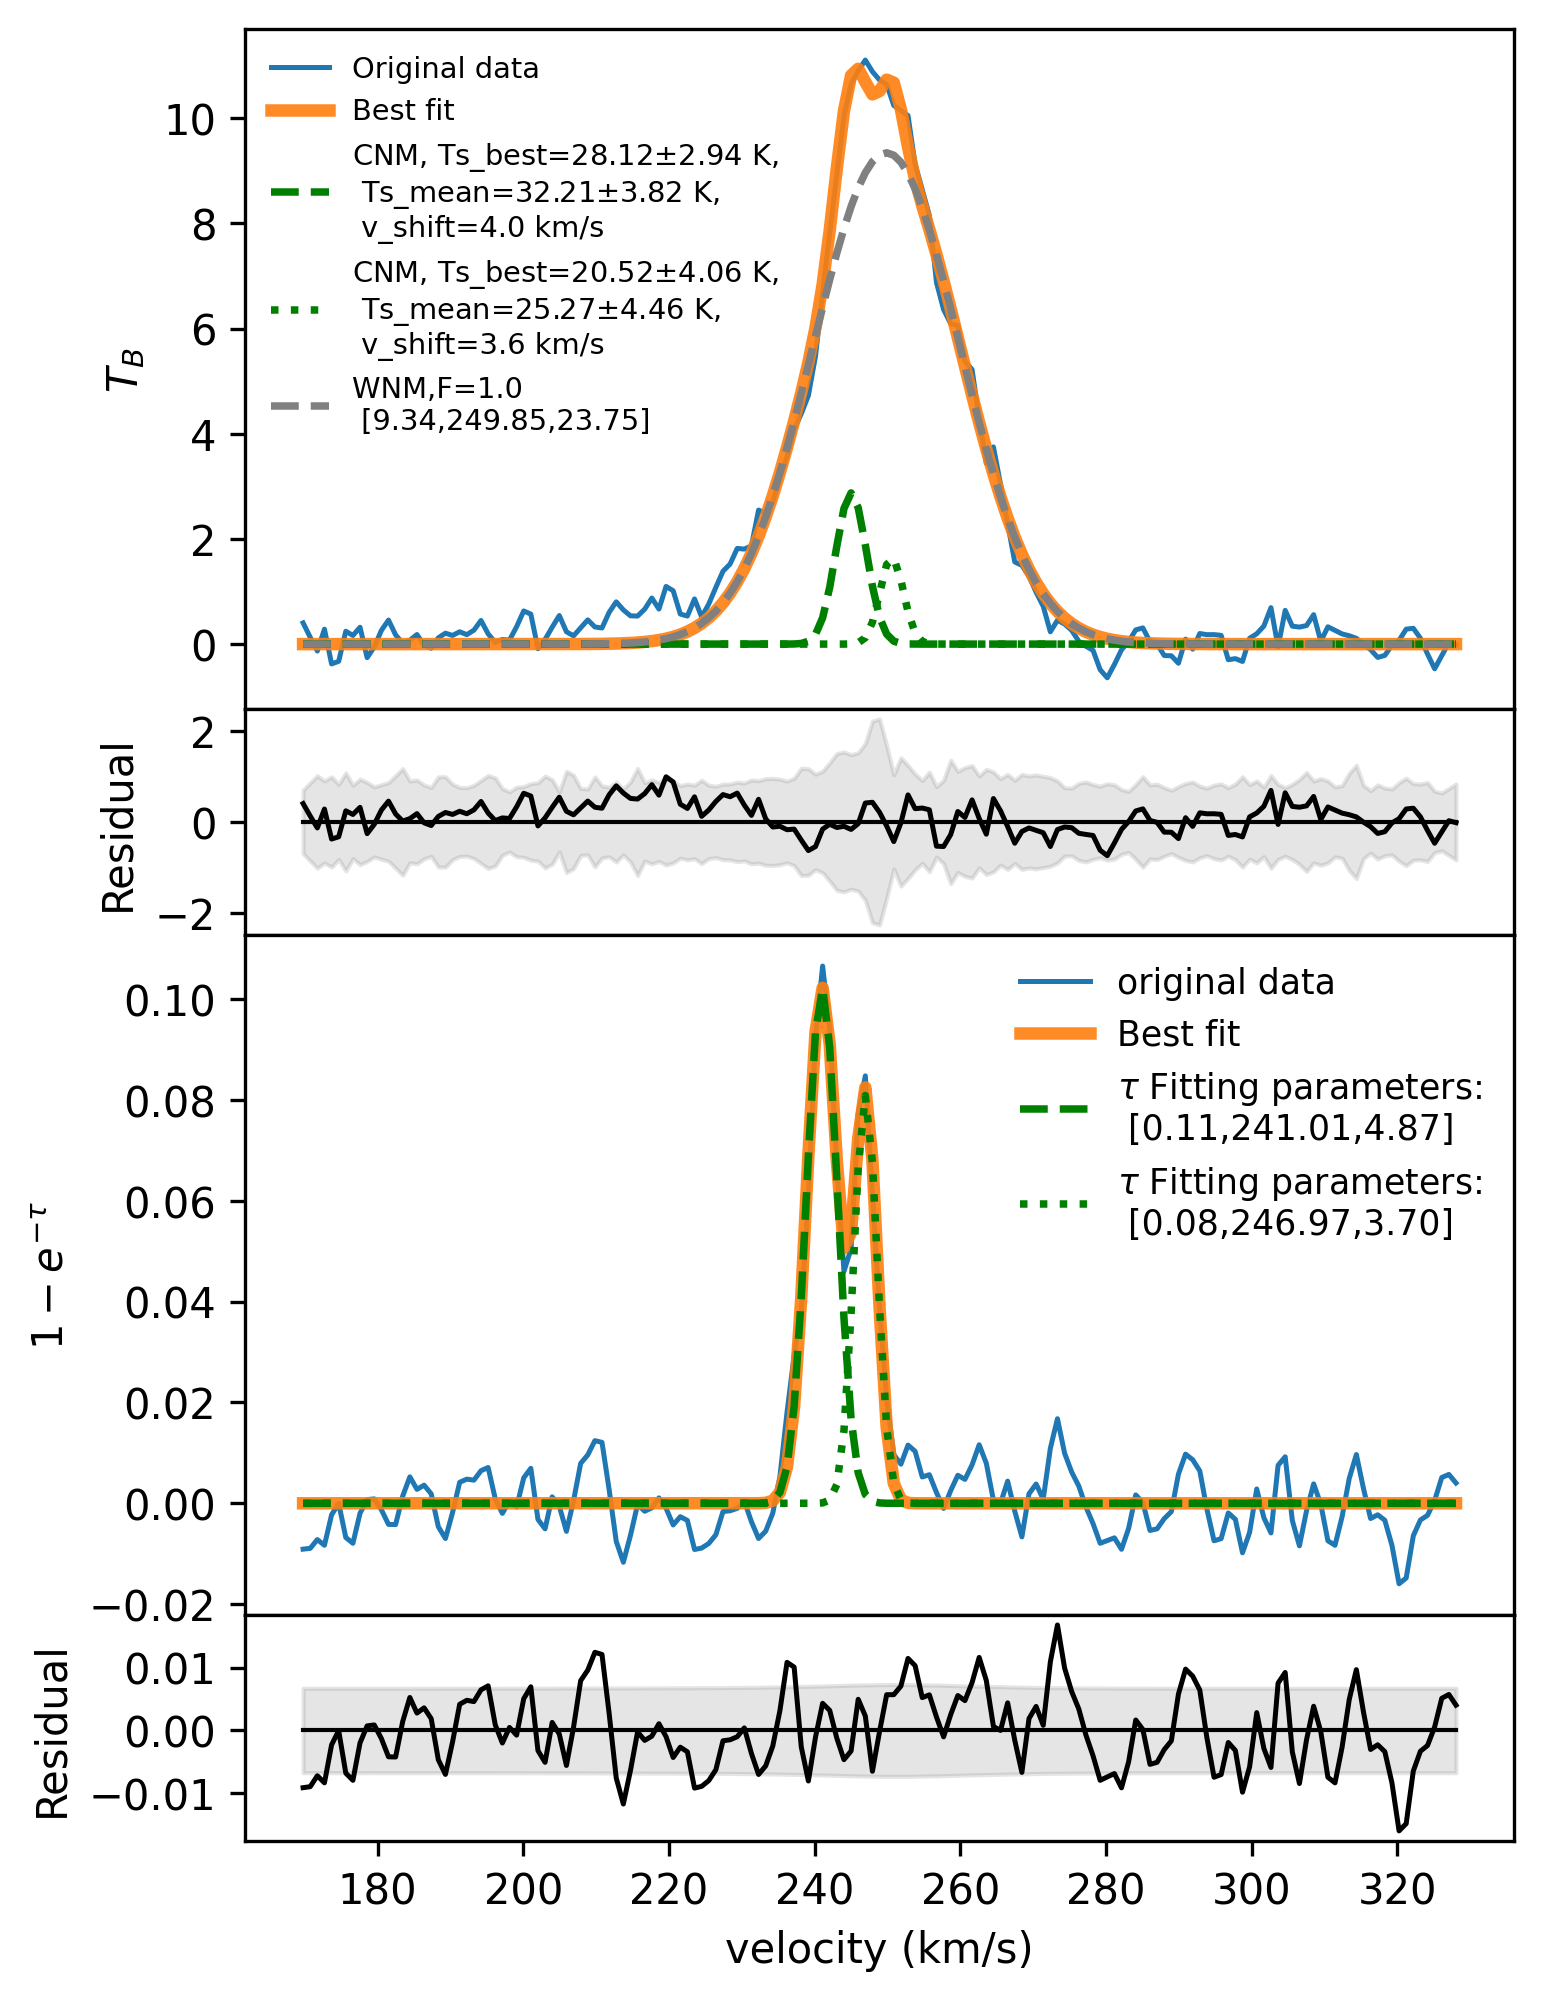

In [ ]:
reload(sd)
reload(Gf)
reload(rd)
j=0
#y should be tau not 1-e^(-tau)
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)

fig = plt.figure(figsize=(12, 8), dpi=300)

ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

ax = [ax1_first,
       plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
       plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
       plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

sd.fit_and_plot(x,y,yerr,xemi,yemi,yemi_err,ax,name=nlist[j],savetxt=False,
                peak_abs=[],peak_emi=[],Tsmin=3.77,
                 fit_mode='BIC',v_sh=4)

#fig.savefig(datapathbase+'/output_data/LMC_fitting/plots/%s.png'%(nlist[j]), dpi=300, bbox_inches='tight') 

In [ ]:
from astropy.coordinates import SkyCoord

def parse_coords(coord_string):
    """
    Convert a coordinate string in the format 'JHHMMSS±DDMMSS' to RA and Dec.

    Parameters:
    coord_string (str): The coordinate string, e.g., 'J053344-721624'.

    Returns:
    tuple: RA (in decimal degrees), Dec (in decimal degrees)
    """
    # Add colons between the components to make it parseable
    ra = coord_string[1:3] + 'h' + coord_string[3:5] + 'm' + coord_string[5:7] + 's'
    dec = coord_string[7:10] + 'd' + coord_string[10:12] + 'm' + coord_string[12:] + 's'
    
    # Create a SkyCoord object with formatted RA and Dec
    coords = SkyCoord(ra + ' ' + dec, frame='icrs')
    
    # Get RA and Dec in decimal degrees
    return coords.ra.degree, coords.dec.degree

# Example usage
coord_string = 'J053344-721624'
ra, dec = parse_coords(coord_string)
print(f"RA: {ra:.6f} degrees, Dec: {dec:.6f} degrees")


RA: 83.433333 degrees, Dec: -72.273333 degrees


In [10]:
ra

83.43333333333332

In [4]:
import os
import psutil

# Number of logical CPU cores
cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {cpu_cores}")

# Available memory
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory.available / (1024 ** 3):.2f} GB")


Number of CPU cores: 32
Total memory: 250.06 GB
Available memory: 242.80 GB


# Multiple j run_decomposing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.votable import parse
import glob
import sys
import os
import Gaussian_fitting as Gf
import spectra_decomposing as sd
import read_GASKAP_data as rd
import time
from multiprocessing import Process, Queue

datapathbase = '/d/bip5/hchen'


def delete_csv_txt_files(directory, file='.csv'):
    if not os.path.isdir(directory):
        print(f"The directory {directory} does not exist.")
        return

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and filename.endswith(file):
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


def process_iteration(j, queue):
    """Function to handle the processing for each j."""
    try:
        print(f"Processing j={j} (PID: {os.getpid()})")
        x, y, yerr, xemi, yemi, yemi_err, yemi_selferr = rd.get_emi_abs_data(
            nlist[j], nabs[j], 1, 1, mode='LMC', v_move=0.
        )

        fig = plt.figure(figsize=(12, 8), dpi=300)
        ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

        ax = [ax1_first,
              plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

        sd.fit_and_plot(x, y, yerr, xemi, yemi, yemi_err, ax, name=nlist[j], savetxt=True,
                        peak_abs=[], peak_emi=[], Tsmin=3.77,
                        fit_mode='BIC', v_sh=4)

        fig.savefig(datapathbase + '/output_data/LMC_fitting/plots/%s.png' % (nlist[j]), dpi=300, bbox_inches='tight')
        queue.put(None)  # Success
    except Exception as e:
        queue.put(str(e))  # Return the exception as a string


def process_wrapper(j, timeout):
    """Wrapper to enforce timeout and handle the process."""
    queue = Queue()
    process = Process(target=process_iteration, args=(j, queue))
    process.start()
    process.join(timeout=timeout)

    if process.is_alive():
        print(f"Timeout for j={j}. Terminating process.")
        process.terminate()
        process.join()
        return j, "Timeout"
    else:
        result = queue.get()  # Get the result from the queue
        if result is None:
            return j, None  # Success
        else:
            return j, result  # Error


def parallel_processing(j_values, max_concurrent_processes=4, timeout=20):
    """Run multiple `j` processes in parallel with timeout enforcement."""
    results = []
    active_processes = {}
    completed_processes = 0

    while completed_processes < len(j_values):
        # Start new processes if we haven't reached the limit
        while len(active_processes) < max_concurrent_processes and j_values:
            j = j_values.pop(0)  # Get the next `j`
            p = Process(target=process_wrapper, args=(j, timeout))
            p.start()
            active_processes[j] = p

        # Check for completed processes
        for j, process in list(active_processes.items()):
            if not process.is_alive():
                process.join()
                result = process_wrapper(j, timeout=timeout)
                results.append(result)
                active_processes.pop(j)
                completed_processes += 1

                # Log timeouts and errors
                if result[1] == "Timeout":
                    f.write(f"{nlist[j]}\n")  # Record the long-running iteration
                    f.flush()  # Ensure immediate write to disk
                    os.fsync(f.fileno())  # Force file system sync
                    print(f"Timeout for j={j}. Logging to long_runs.txt.")
                elif result[1] is not None:
                    print(f"Error for j={j}: {result[1]}")

        time.sleep(0.1)  # Avoid busy-waiting

    return results


if __name__ == "__main__":
    directory_to_check = datapathbase + "/output_data/LMC_fitting"

    nemi = np.sort(glob.glob(datapathbase + '/LMC_GASKAP_emi_all_abs/*.txt'))
    nabs_n = glob.glob(datapathbase + '/LMC_abs_new/sb*')
    nabs = [None] * len(nemi)
    for i, ni in enumerate(nemi):
        na_ = ni[-18:-4]
        for nj in nabs_n:
            _ = glob.glob(nj + '/spectra_abs/*')
            _all = [filename[-23:-9] for filename in _]
            if na_ in _all:
                if nabs[i] is not None:
                    break
                else:
                    nabs[i] = f'{nj}/spectra_abs/{na_}_spec.vot'

    nemi, nabs = np.array(nemi), np.array(nabs)
    nlist = [filename[-18:-4] for filename in nemi]

    # Prepare the list of `j` values to process
    j_values = list(range(96, 222))

    # Timeout and number of concurrent processes
    max_concurrent_processes = 1  # Number of parallel processes
    timeout = 20  # Timeout for each task in seconds

    # Open the file to log long-running iterations
    with open(datapathbase + '/output_data/LMC_fitting/long_runs.txt', 'a') as f:
        results = parallel_processing(j_values, max_concurrent_processes=max_concurrent_processes, timeout=timeout)

       


Processing j=96 (PID: 1383734)
BIC  10911.639965425096 n=1
BIC  4458.742555782 n= 2
BIC  1738.2048569413564 n= 3
BIC  281.1631828075366 n= 4
BIC  241.64508914115618 n= 5
BIC  227.46573936534395 n= 6
final n= 5
[283.16408132 280.61563809 269.51824148 294.56987779 302.76312519]
BIC= 267.20288492821504
popt_ori [1.39834790e-01 2.94507231e+02 3.42492963e+00 7.60381207e-01
 2.80723221e+02 9.81689491e-01 1.97746083e-01 2.69522704e+02
 1.68701242e+00 3.88488319e-01 2.83028018e+02 2.96477619e+00
 3.03977920e-02 3.02766938e+02 1.31307399e+00]
Ts_low limit [30.66289193318271, 25.129637148247834, 27.505073401307186, 25.23127077476328, 47.708987135444666]
Timeout for j=96. Terminating process.
Processing j=96 (PID: 1383881)
BIC  10911.639965425096 n=1
BIC  4458.742555782 n= 2
BIC  1738.2048569413564 n= 3
BIC  281.1631828075366 n= 4
BIC  241.64508914115618 n= 5
BIC  227.46573936534395 n= 6
final n= 5
[283.16408132 280.61563809 269.51824148 294.56987779 302.76312519]
BIC= 267.20288492821504
popt_ori

KeyboardInterrupt: 

BIC  80.79796559303745 Mean_score  84.24356810925936
Ts>3.77 (18,)
Ts>3.77 (18,)
Ts>3.77 (18,)
final BIC  82.4760786249771
67.4760786249771
velocity shift [-1.75412484 -1.0041757  -2.72553104]
nhi_c: 5.548566052523404 0.35255496229781585
nhi_w: 6.546463151028759 0.07250572590840086
fc: 0.4587476358381886 0.016014713827403087



In [ ]:
nlist[96:100], 'J051418-673528'

['J051537-672127', 'J051637-723710', 'J051641-714905', 'J051716-702357']

# original single run_secomposing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.votable import parse
import glob

import sys,os
import Gaussian_fitting as Gf
#sys.path.append('../Absorption_fitting')
import spectra_decomposing as sd
import read_GASKAP_data as rd
import time
from multiprocessing import Process, Queue

datapathbase='/d/bip5/hchen'


def delete_csv_txt_files(directory,file='.csv'):
    """
    Deletes all .csv and .txt files in the specified directory.

    Args:
        directory (str): Path to the directory.
    """
    # Ensure the directory exists
    if not os.path.isdir(directory):
        print(f"The directory {directory} does not exist.")
        return

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Check if it's a file and has .csv or .txt extension
        if os.path.isfile(file_path) and (filename.endswith(file)):
            try:
                os.remove(file_path)  # Delete the file
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


def process_iteration(j, queue):
    """Function to handle the processing for each j."""
    try:
        print(f"Processing j={j} (PID: {os.getpid()})")
        x, y, yerr, xemi, yemi, yemi_err, yemi_selferr = rd.get_emi_abs_data(
            nlist[j], nabs[j], 1, 1, mode='LMC', v_move=0.
        )

        fig = plt.figure(figsize=(12, 8), dpi=300)
        ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

        ax = [ax1_first,
              plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

        sd.fit_and_plot(x, y, yerr, xemi, yemi, yemi_err, ax, name=nlist[j], savetxt=True,
                        peak_abs=[], peak_emi=[], Tsmin=3.77,
                        fit_mode='BIC', v_sh=4)

        fig.savefig(datapathbase + '/output_data/LMC_fitting/plots/%s.png' % (nlist[j]), dpi=300, bbox_inches='tight')
        sys.stdout.flush()
    except Exception as e:
        queue.put(e)  # Send the exception back to the parent process
    finally:
        queue.put(None)  # Signal the completion of the task


if __name__ == "__main__":
    # Example usage
    directory_to_check = datapathbase+"/output_data/LMC_fitting"
    #delete_csv_txt_files(directory_to_check,file='.csv')
    #delete_csv_txt_files(directory_to_check,file='.txt')
    #delete_csv_txt_files(directory_to_check+'/plots',file='.png')
    #idx = int(sys.argv[1])
    #print sources observed twice
    nemi=np.sort(glob.glob(datapathbase+'/LMC_GASKAP_emi_all_abs/*.txt'))
    nabs_n=glob.glob(datapathbase+'/LMC_abs_new/sb*')
    nabs=[None] * len(nemi)
    for i, ni in enumerate(nemi):
        na_=ni[-18:-4]
        for nj in nabs_n:
            _=glob.glob(nj+'/spectra_abs/*')
            _all=[filename[-23:-9] for filename in _]
            if na_ in _all:
                if nabs[i] is not None:
                    #print(i,nj,na_)
                    break  # Exit the loop once a match is found for this `na_`
                else:
                    nabs[i] = f'{nj}/spectra_abs/{na_}_spec.vot'  # Record `nj` only once for this `na_`
                    
    nemi,nabs=np.array(nemi),np.array(nabs)  
    nlist=[filename[-18:-4] for filename in nemi]
    #0-18:original
    #19-84:not change Gaussian fitting
    # Define a timeout handler


# Open the file to log long-running iterations
    with open(datapathbase + '/output_data/LMC_fitting/long_runs.txt', 'a') as f:
        for j in range(87, 222):
            start_time = time.time()

            queue = Queue()
            process = Process(target=process_iteration, args=(j, queue))
            process.start()
            process.join(timeout=30*60)  # Allow 30*60 seconds for processing

            if process.is_alive():
                # Timeout occurred
                print(f"Timeout for j={j}, skipping to next.")
                try:
                    f.write(f"{nlist[j]}\n")  # Record the long-running iteration
                    f.flush()  # Ensure immediate write to disk
                    os.fsync(f.fileno())  # Force file system sync
                except Exception as e:
                    print(f"Error writing to log file: {e}")
                process.terminate()  # Terminate the process
                process.join()  # Ensure the process is fully cleaned up
            else:
                # Check if an error occurred in the process
                result = queue.get()
                if result is not None:
                    print(f"Error processing {nlist[j]}: {result}")

            elapsed_time = time.time() - start_time
            print(f"Elapsed time for j={j}: {elapsed_time:.2f} seconds")
            #print(j,nlist[j],end='\r', flush=True)
            #nohup /bin/python3 run_decompose.py > output.log 2>&1 &
            #ps aux | grep run_decompose.py
                    